In [33]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

In [50]:
def collect_data(root_dir):
    """
    Collects and processes energy and magnetization data from CSV files organized in subdirectories by temperature (T) and lattice size (L).

    Args:
        root_dir (str): Path to the main directory containing subdirectories named "T = {number}".

    Returns:
        dict: A nested dictionary where data[T][L] contains 'energy' and 'magnetization' arrays averaged over blocks of 100.
    """
    data = defaultdict(dict)  # data[T][L] = {'energy': ..., 'magnetization': ...}

    # Iterate over each subdirectory (T folders) in root_dir
    for t_entry in os.scandir(root_dir):
        if t_entry.is_dir() and t_entry.name.startswith('T='):
            # Extract T value
            print(f"Found Dir:{t_entry}")
            t_str = t_entry.name.split('=')[1].strip()
            try:
                T = float(t_str)
            except ValueError:
                print(f"Skipping invalid T folder: {t_entry.name}")
                continue

            # Process each CSV file in the T folder
            for l_entry in os.scandir(t_entry.path):
                if l_entry.is_file() and l_entry.name.endswith('.csv'):
                    # Extract L value from filename
                    l_filename = l_entry.name
                    l_str = l_filename.split('L=')[1].split('.')[0].strip()
                    print(l_str)
                    try:
                        L = int(l_str)
                    except ValueError:
                        print(f"Skipping invalid L file: {l_filename}")
                        continue

                    # Read CSV data, skipping the first row
                    try:
                        data_csv = np.genfromtxt(l_entry.path, delimiter=',', skip_header=1)
                    except Exception as e:
                        print(f"Error reading {l_entry.path}: {e}")
                        continue

                    # Check data shape
                    if data_csv.ndim != 2 or data_csv.shape[1] != 2:
                        print(f"File {l_entry.path} has invalid shape {data_csv.shape}. Skipping.")
                        continue

                    energy = data_csv[:, 0]
                    magnetization = data_csv[:, 1]
                    
                    # Store in data structure
                    data[T][L] = {
                        'energy': energy,
                        'magnetization': magnetization
                    }

    return data

In [91]:
# Example usage:
data = collect_data(os.getcwd() + "//thermal_averaging_data")


Found Dir:<DirEntry 'T=1.6000000000000005'>
32
16
8
64
Found Dir:<DirEntry 'T=3.1999999999999966'>
8
32
64
16
Found Dir:<DirEntry 'T=1.05'>
16
64
32
8
Found Dir:<DirEntry 'T=2.25'>
32
64
8
16
Found Dir:<DirEntry 'T=3.099999999999997'>
8
32
64
16
Found Dir:<DirEntry 'T=3.4499999999999957'>
8
32
16
64
Found Dir:<DirEntry 'T=2.3'>
64
16
32
8
Found Dir:<DirEntry 'T=2.9999999999999973'>
32
64
8
16
Found Dir:<DirEntry 'T=2.2'>
64
16
32
8
Found Dir:<DirEntry 'T=2.1500000000000004'>
16
64
32
8
Found Dir:<DirEntry 'T=3.399999999999996'>
32
64
8
16
Found Dir:<DirEntry 'T=2.3999999999999995'>
32
64
8
16
Found Dir:<DirEntry 'T=3.349999999999996'>
16
8
64
32
Found Dir:<DirEntry 'T=1.7500000000000007'>
32
8
64
16
Found Dir:<DirEntry 'T=1.8500000000000008'>
16
64
8
32
Found Dir:<DirEntry 'T=2.799999999999998'>
64
16
32
8
Found Dir:<DirEntry 'T=1.5000000000000004'>
32
64
8
16
Found Dir:<DirEntry 'T=1.2000000000000002'>
8
32
64
16
Found Dir:<DirEntry 'T=1.4000000000000004'>
64
16
32
8
Found Dir:<DirEnt

0.20506392045454547


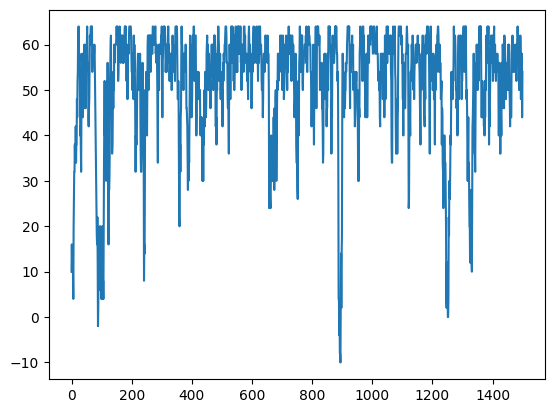

In [92]:
plt.plot(data[2.2][8]['magnetization'][:])
print(np.mean(data[2.2][8]['magnetization'][400:])/(16**2))

<>:75: SyntaxWarning: invalid escape sequence '\c'
<>:75: SyntaxWarning: invalid escape sequence '\c'
/var/folders/k2/zy9ml31s19q4qf3bm2dx4p8m0000gn/T/ipykernel_9071/3543783899.py:75: SyntaxWarning: invalid escape sequence '\c'
  ax4.set_ylabel('Magnetic Susceptibility ($\chi$)')


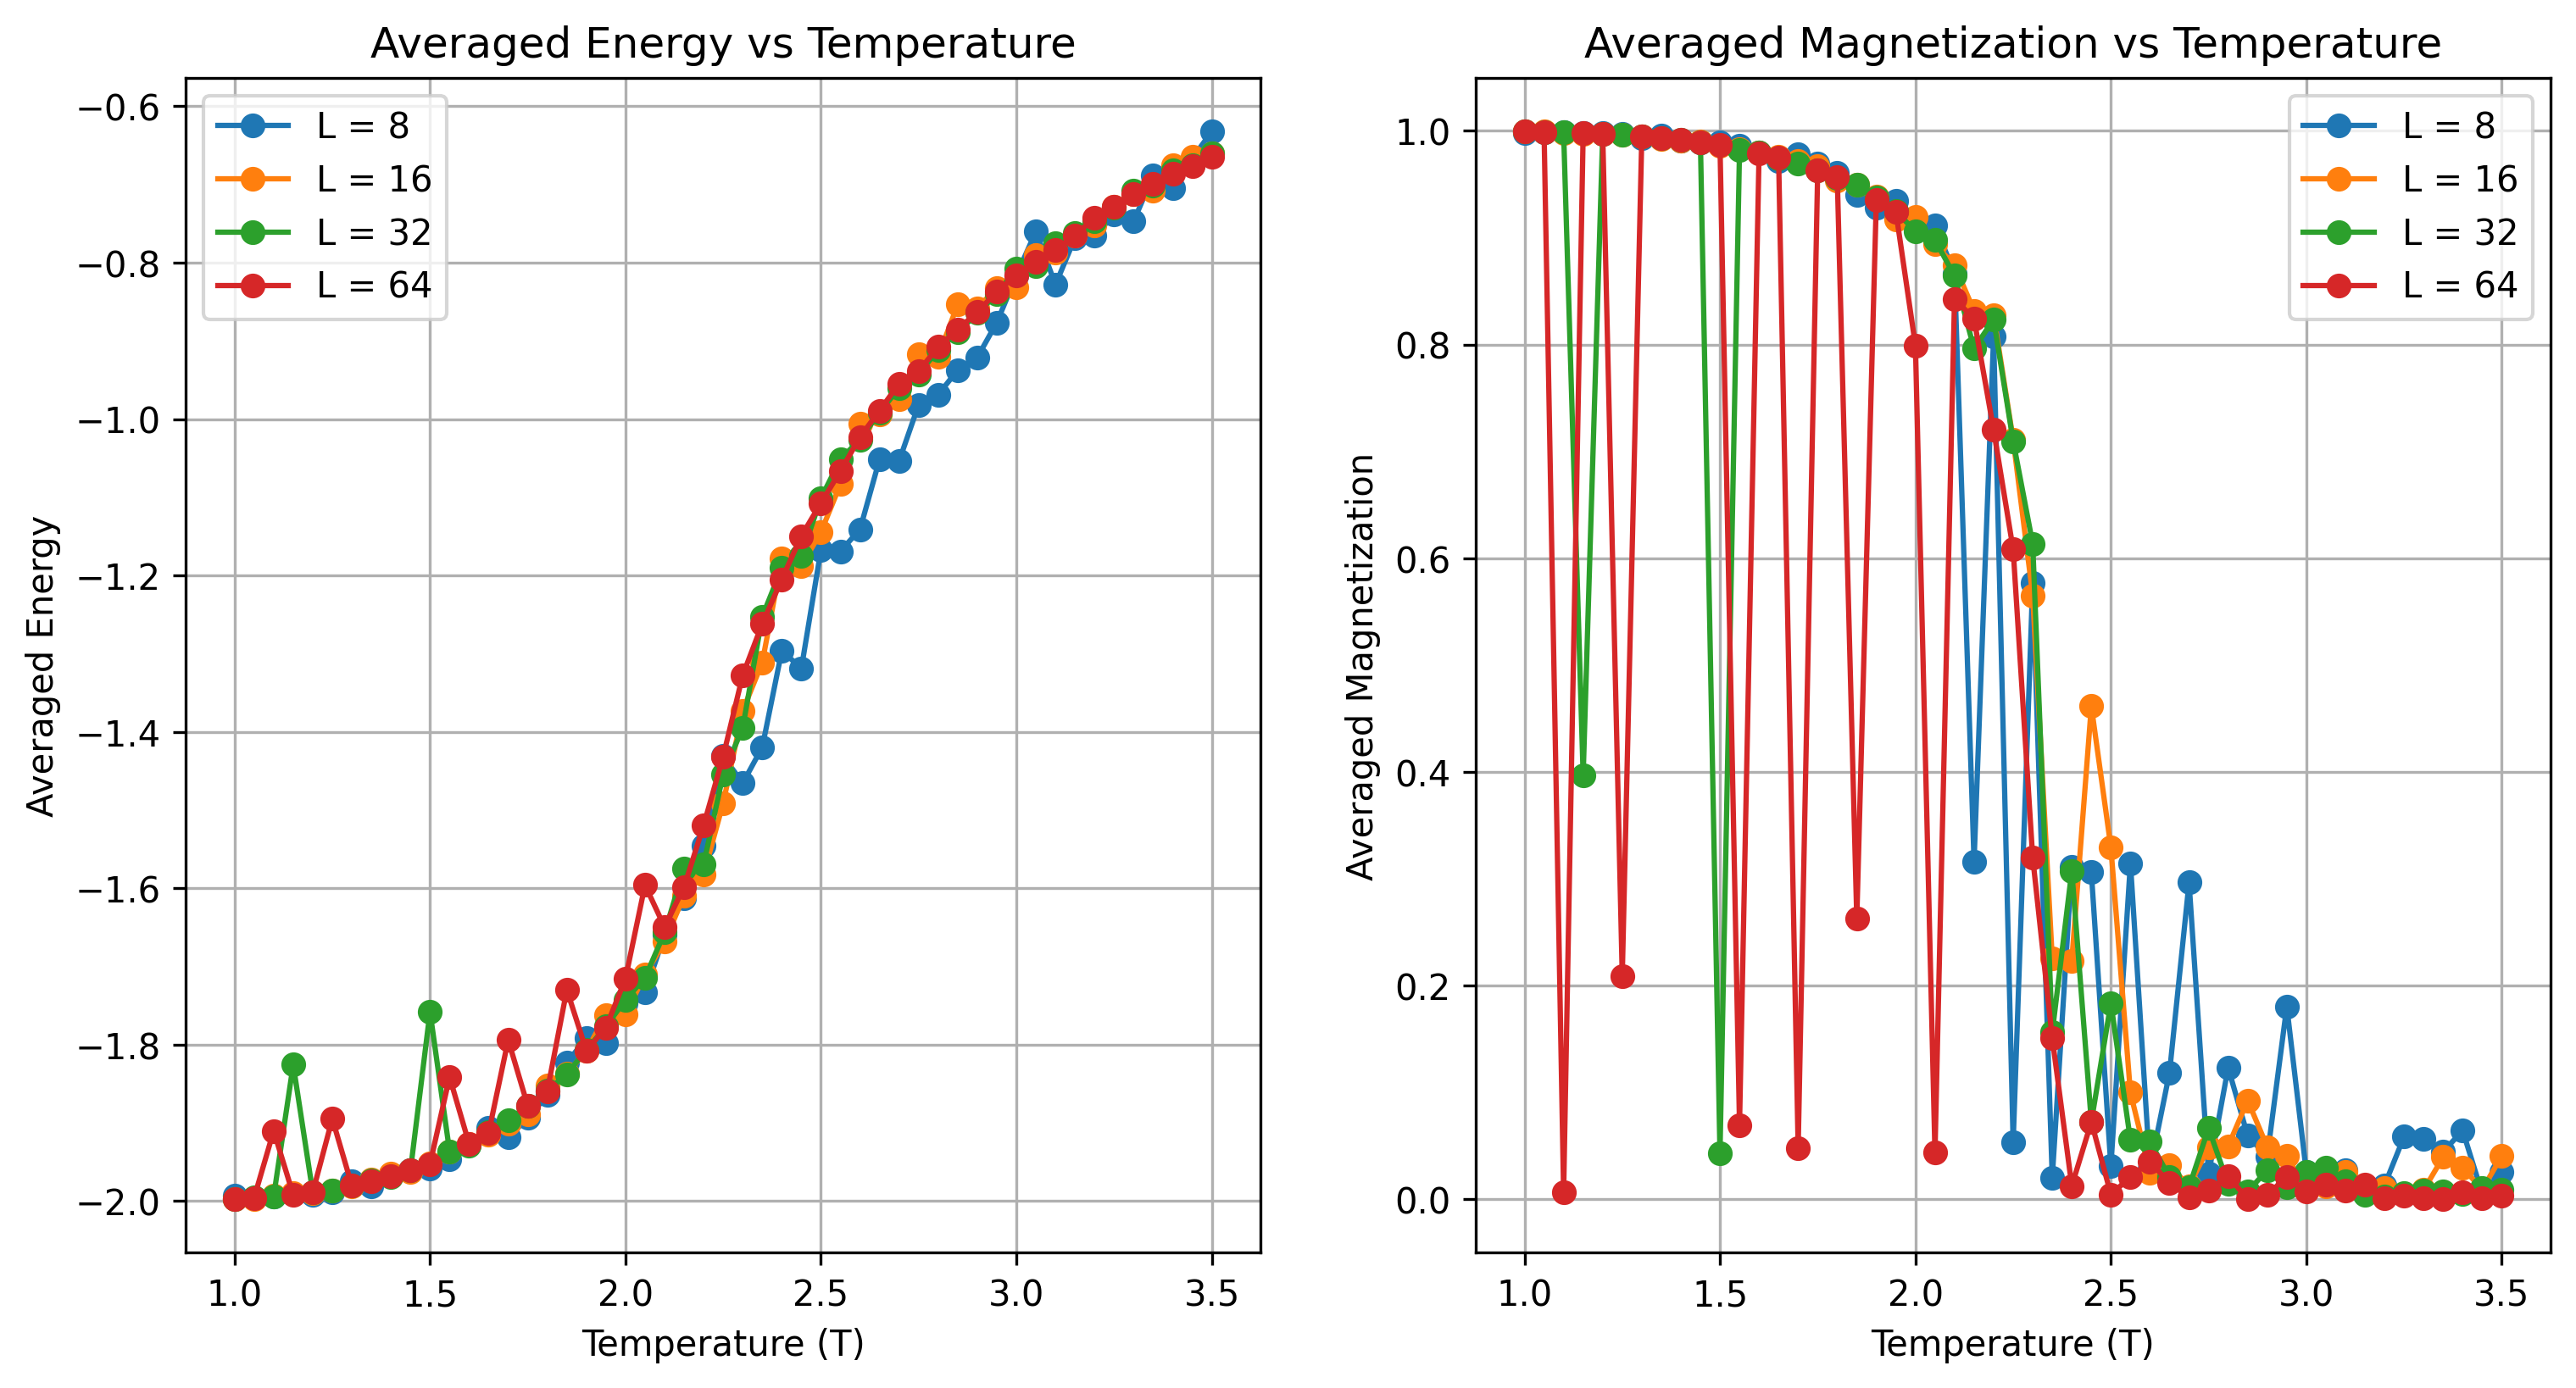

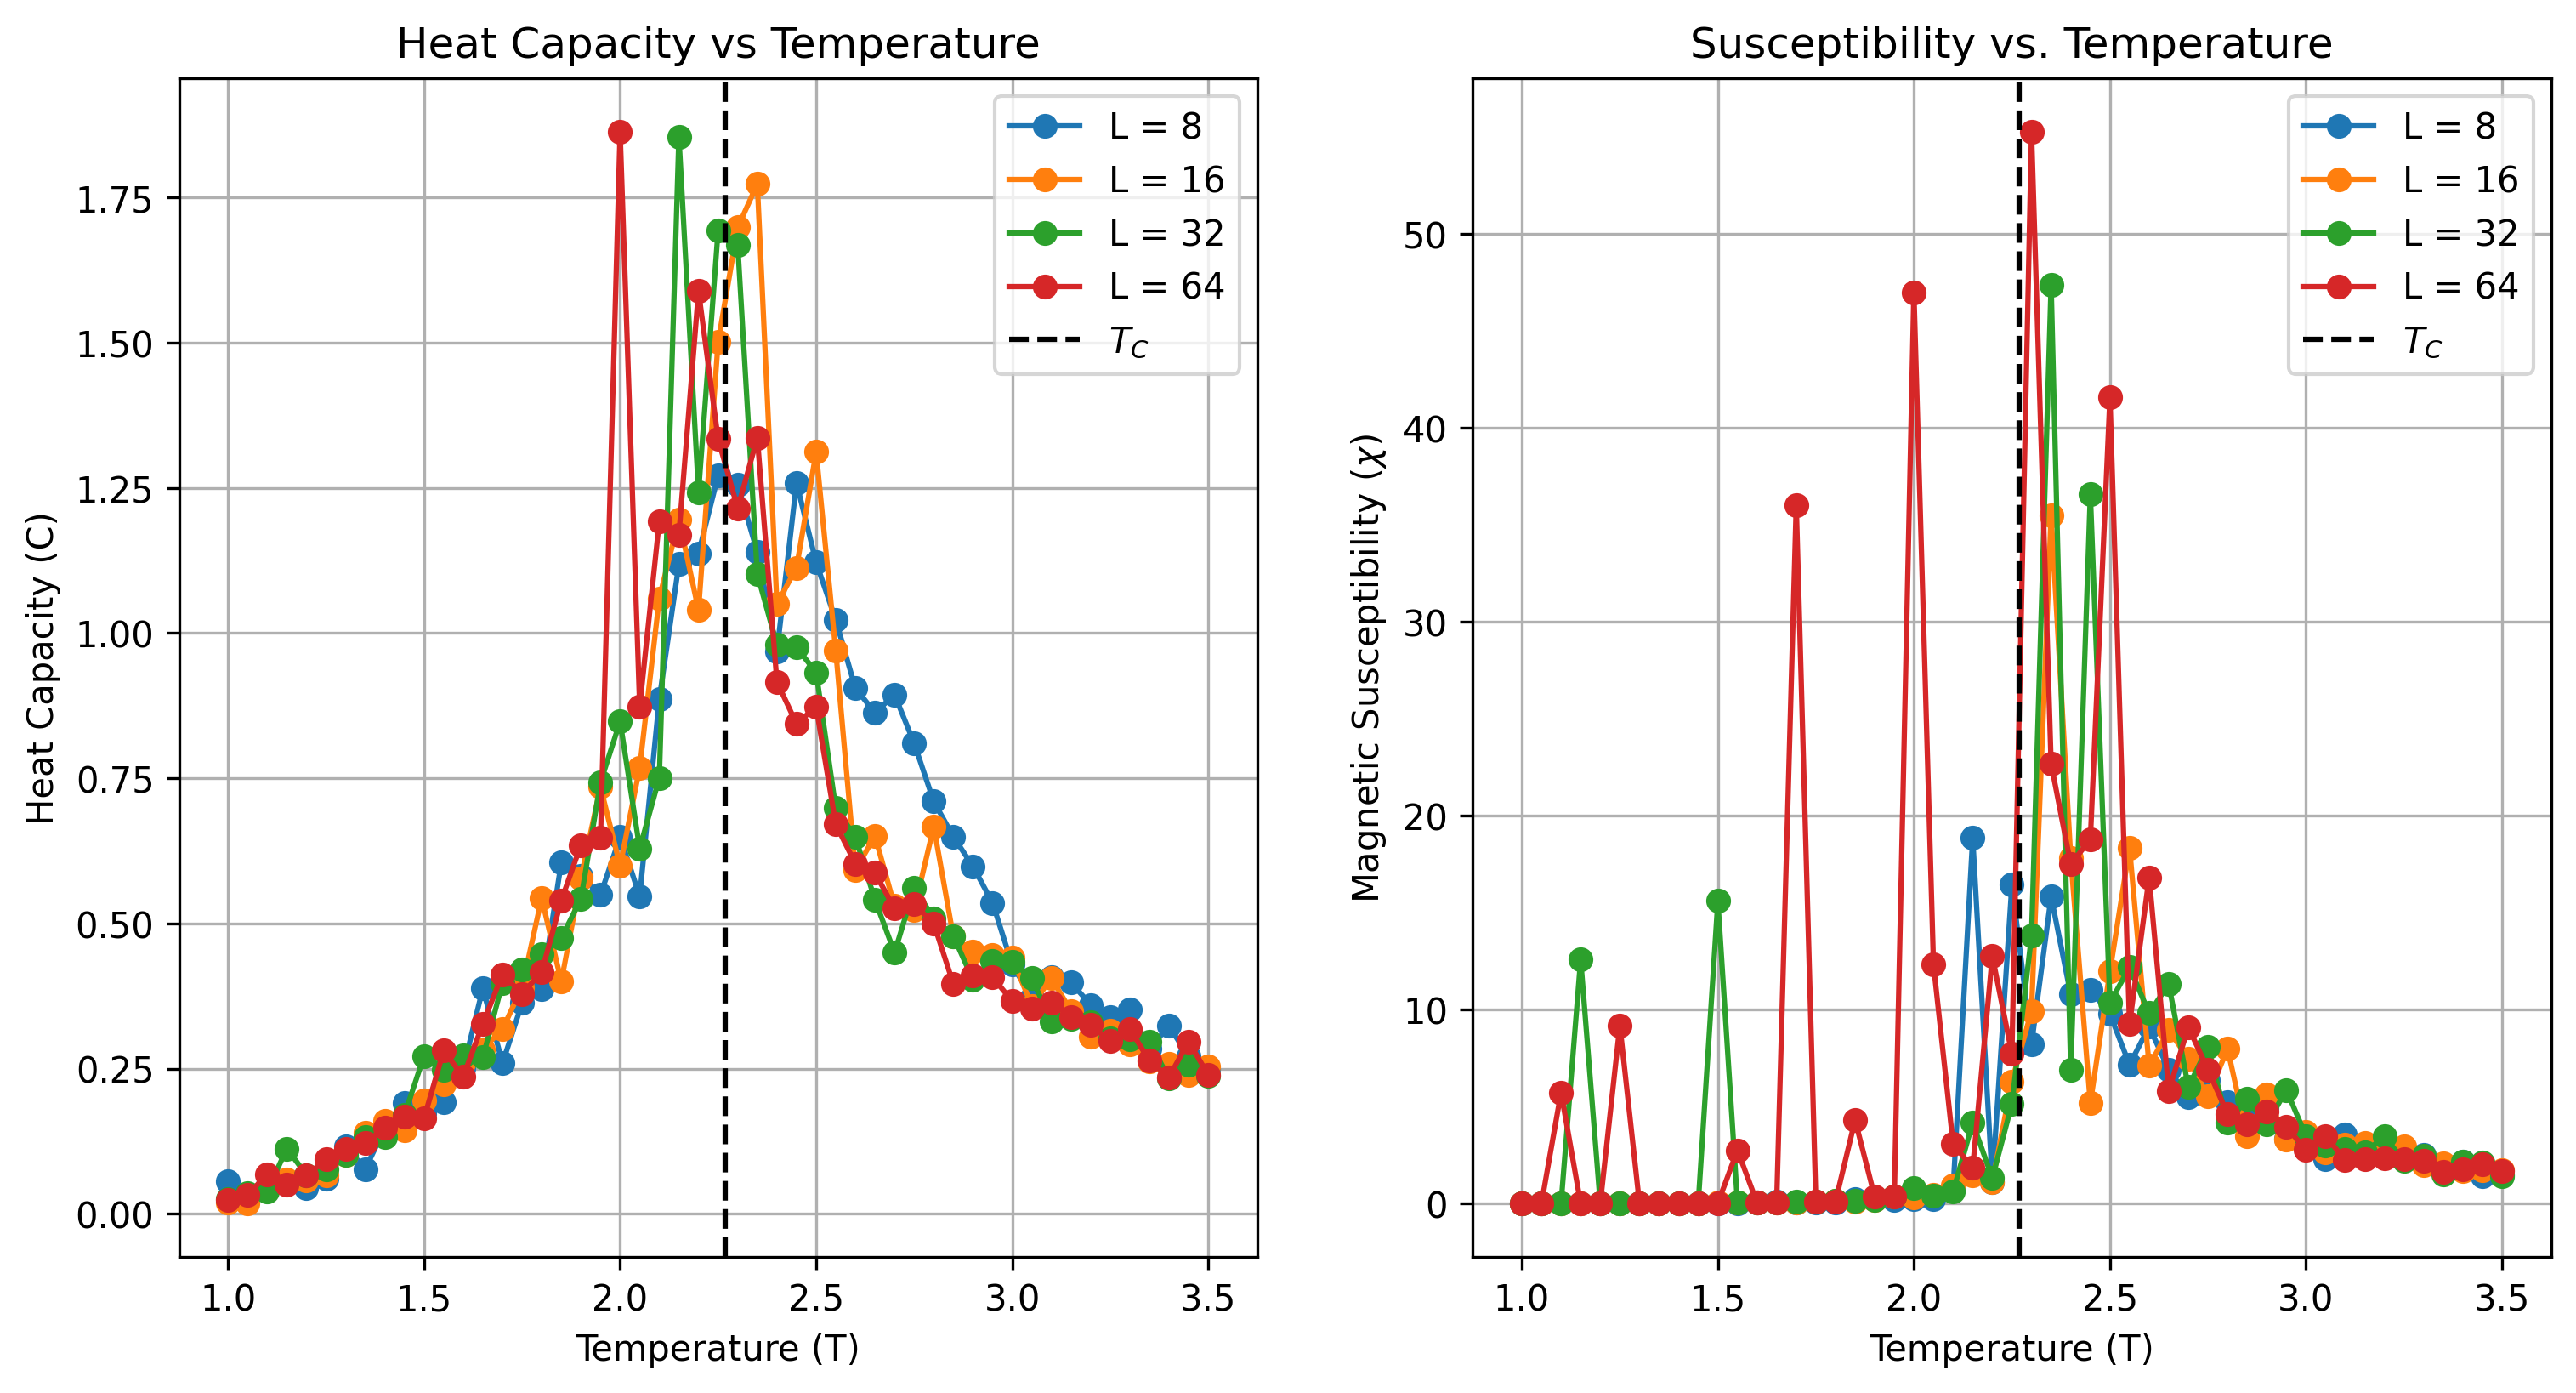

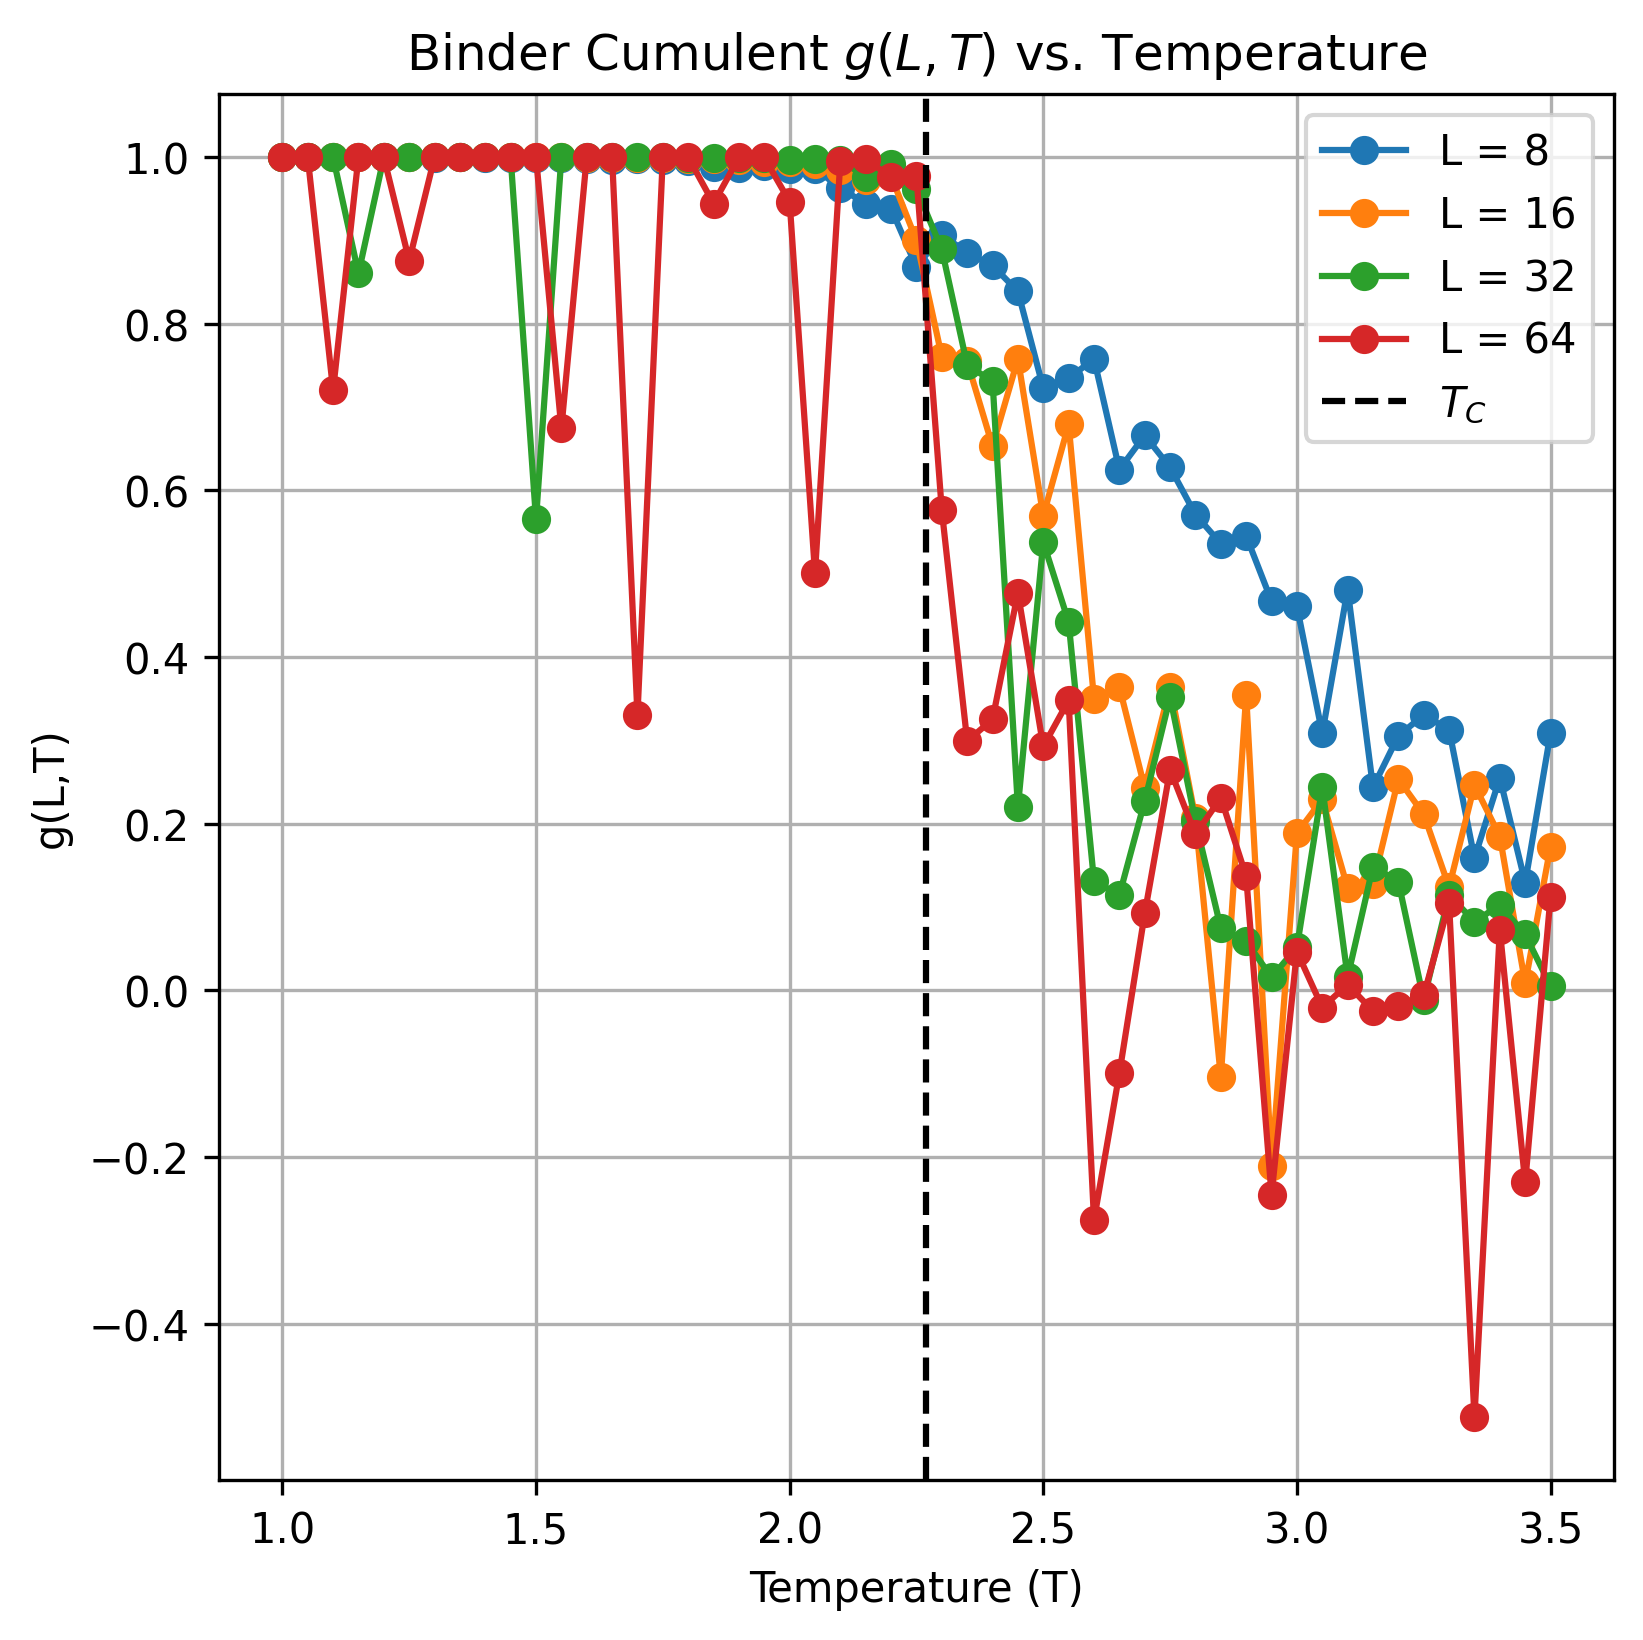

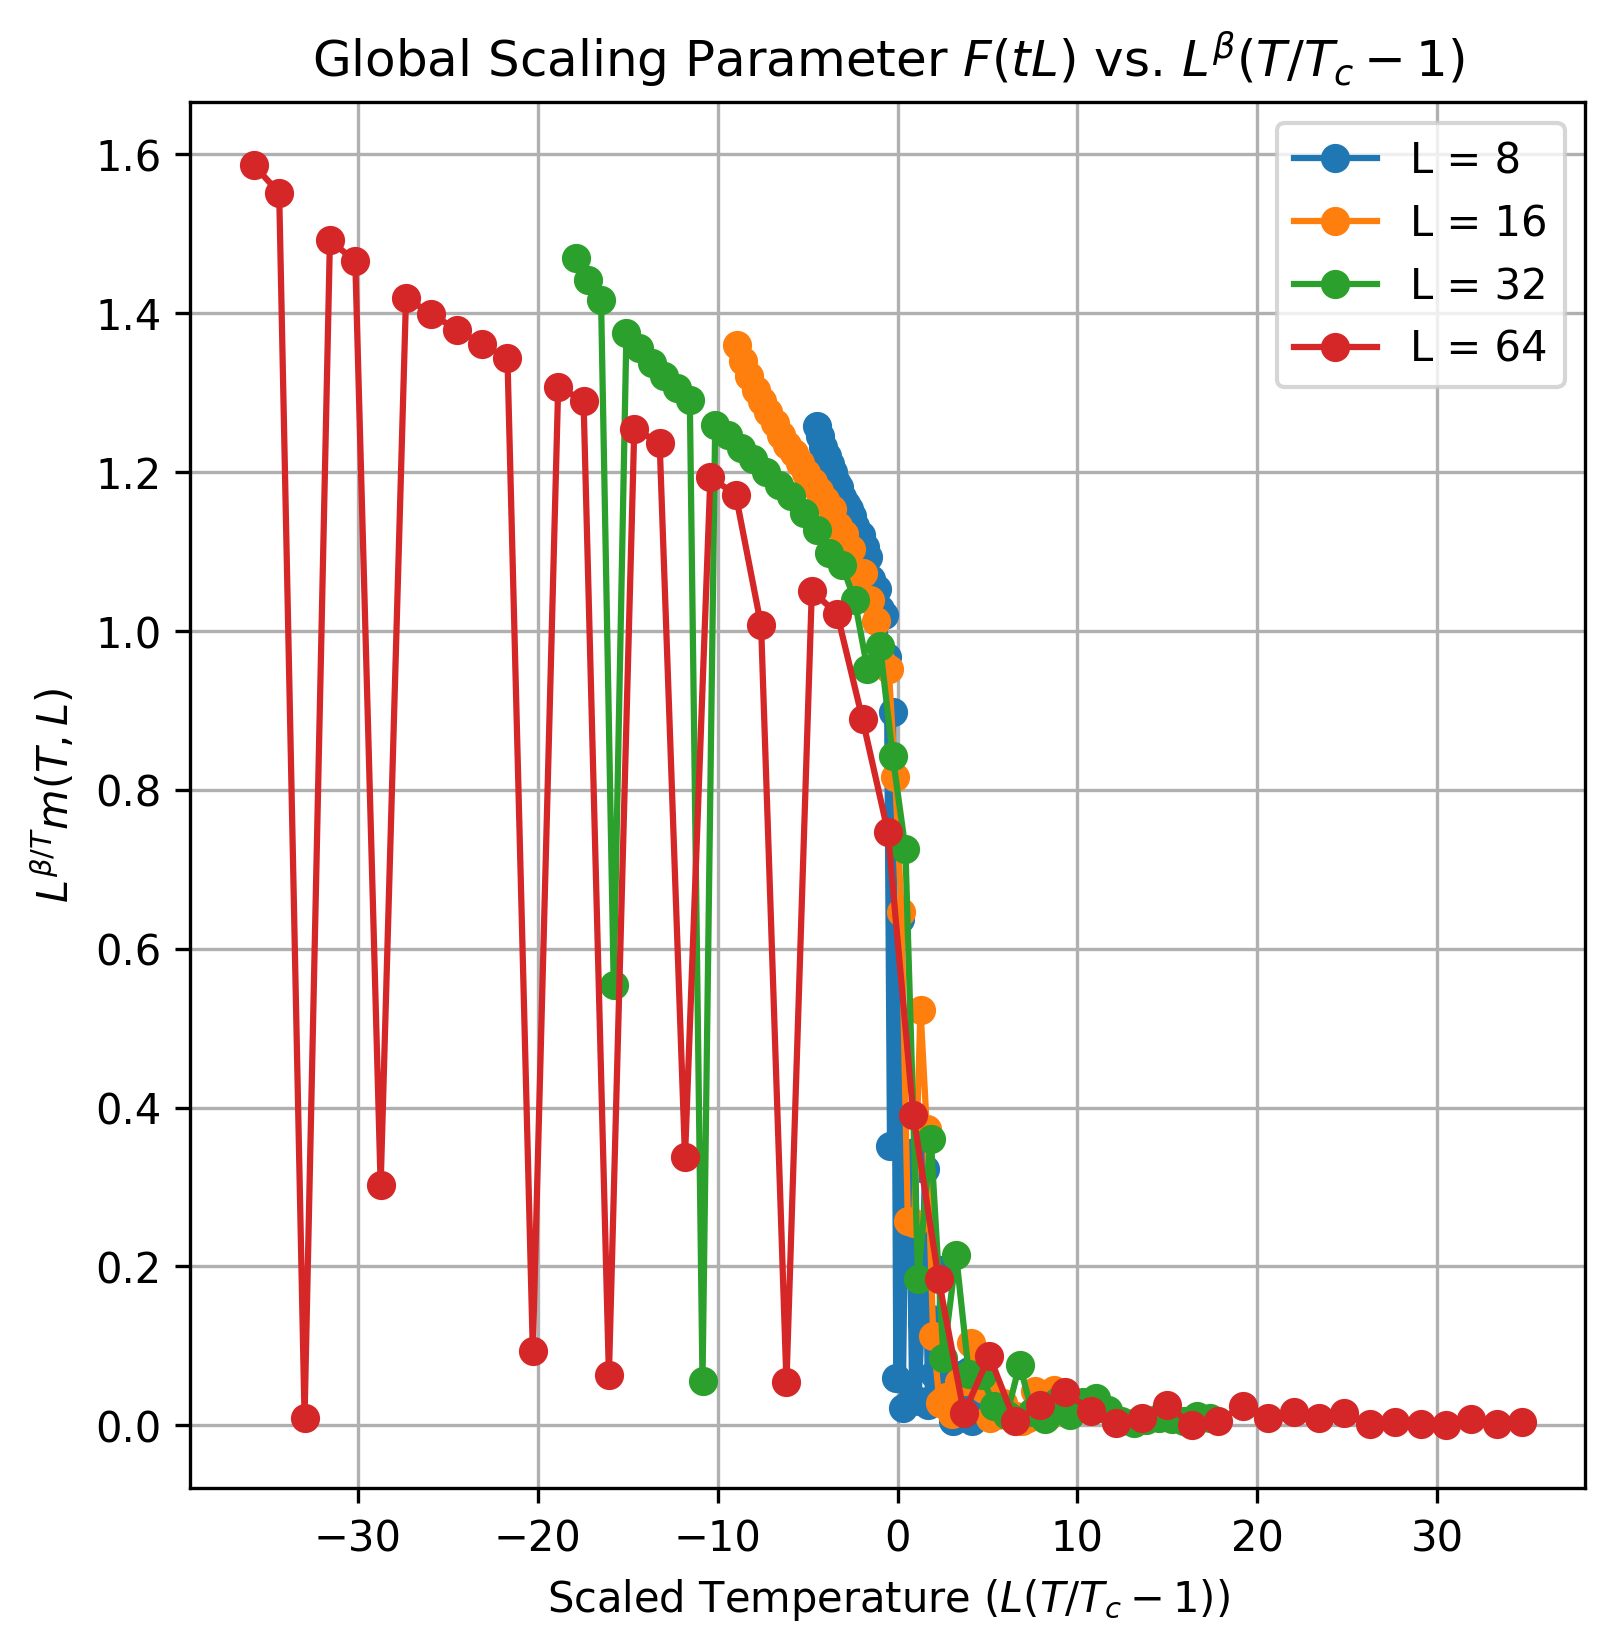

In [130]:
# Data[T][L]["energy", "magnetization"]
# - each index is a set of averaged temperatures
n_min = 800
# Extract unique lattice sizes (L) from the data
lattice_sizes = set()
for T in data:
    lattice_sizes.update(data[T].keys())
lattice_sizes = sorted(lattice_sizes)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), dpi = 300)
fig2, (ax3, ax4) = plt.subplots(nrows=1, ncols=2, figsize = (12,6), dpi = 300)
fig3, ax5 = plt.subplots(nrows=1, ncols=1, figsize = (6,6), dpi = 300)
fig4, ax6 = plt.subplots(nrows=1, ncols=1, figsize = (6,6), dpi = 300)

# Create a plot for each lattice size
for L in lattice_sizes:
    temperatures = []
    energies = []
    magnetizations = []

    energy_variance = []
    magnet_variance = []

    binder_cumulent = []

    # Collect data for this lattice size
    for T in sorted(data.keys()):
        if L in data[T]:
            temperatures.append(T)
            # <E>
            energies.append(np.mean(data[T][L]['energy'][n_min:]))  # Use mean of averaged energy
            # <M>
            magnetizations.append(np.mean(data[T][L]['magnetization'][n_min:]))  # Use mean of averaged energy
            # <E^2>
            energy_variance.append(np.mean(np.array(data[T][L]['energy'][n_min:])**2))
            # <M^2>
            magnet_variance.append(np.mean(np.array(data[T][L]['magnetization'][n_min:])**2))
            # <M^4>
            binder_cumulent.append(np.mean(np.array(data[T][L]['magnetization'][n_min:])**4))

    # Plot energy vs temperature for this lattice size
    ax1.plot(temperatures, np.array(energies)/L**2, marker='o', label=f'L = {L}')
    ax2.plot(temperatures, np.abs(np.array(magnetizations))/(L**2), marker='o', label=f'L = {L}')
    ax3.plot(temperatures, 1/np.array(temperatures)**2 *(np.array(energy_variance) - np.array(energies)**2)/L**2, marker='o', label=f'L = {L}')
    ax4.plot(temperatures, 1/np.array(temperatures) * (np.array(magnet_variance) - np.array(magnetizations)**2)/L**2, marker='o', label=f'L = {L}')
    ax5.plot(temperatures, 1.5 - (np.array(binder_cumulent)/(2 * np.array(magnet_variance)**2)), marker='o', label=f'L = {L}')
    beta = 1/9
    ax6.plot(L * (np.array(temperatures)/2.269 - 1 ), L**(beta/np.array(temperatures)) * np.abs(np.array(magnetizations))/(L**2), marker='o', label=f'L = {L}')

# Add labels and legend
ax1.set_xlabel('Temperature (T)')
ax1.set_ylabel('Averaged Energy')
ax1.set_title('Averaged Energy vs Temperature')
ax1.legend()
ax1.grid(True)

# Add labels and legend
ax2.set_xlabel('Temperature (T)')
ax2.set_ylabel('Averaged Magnetization')
ax2.set_title('Averaged Magnetization vs Temperature')
ax2.legend()
ax2.grid(True)

# Add labels and legend
ax3.axvline(x=2.269, color="black", linestyle="--", label="$T_C$")
ax3.set_xlabel('Temperature (T)')
ax3.set_ylabel('Heat Capacity (C)')
ax3.set_title('Heat Capacity vs Temperature')
ax3.legend()
ax3.grid(True)

# Add labels and legend
ax4.axvline(x=2.269, color="black", linestyle="--", label="$T_C$")
ax4.set_xlabel('Temperature (T)')
ax4.set_ylabel('Magnetic Susceptibility ($\chi$)')
ax4.set_title('Susceptibility vs. Temperature')
ax4.legend()
ax4.grid(True)

# Add labels and legend
ax5.axvline(x=2.269, color="black", linestyle="--", label="$T_C$")
ax5.set_xlabel('Temperature (T)')
ax5.set_ylabel('g(L,T)')
ax5.set_title('Binder Cumulent $g(L,T)$ vs. Temperature')
ax5.legend()
ax5.grid(True)

# Add labels and legend
ax6.set_xlabel('Scaled Temperature ($L(T/T_c - 1)$)')
ax6.set_ylabel('$L^{β/T} m(T,L)$')
ax6.set_title('Global Scaling Parameter $F(tL)$ vs. $L^{β}(T/T_c - 1)$')
ax6.legend()
ax6.grid(True)

plt.show()

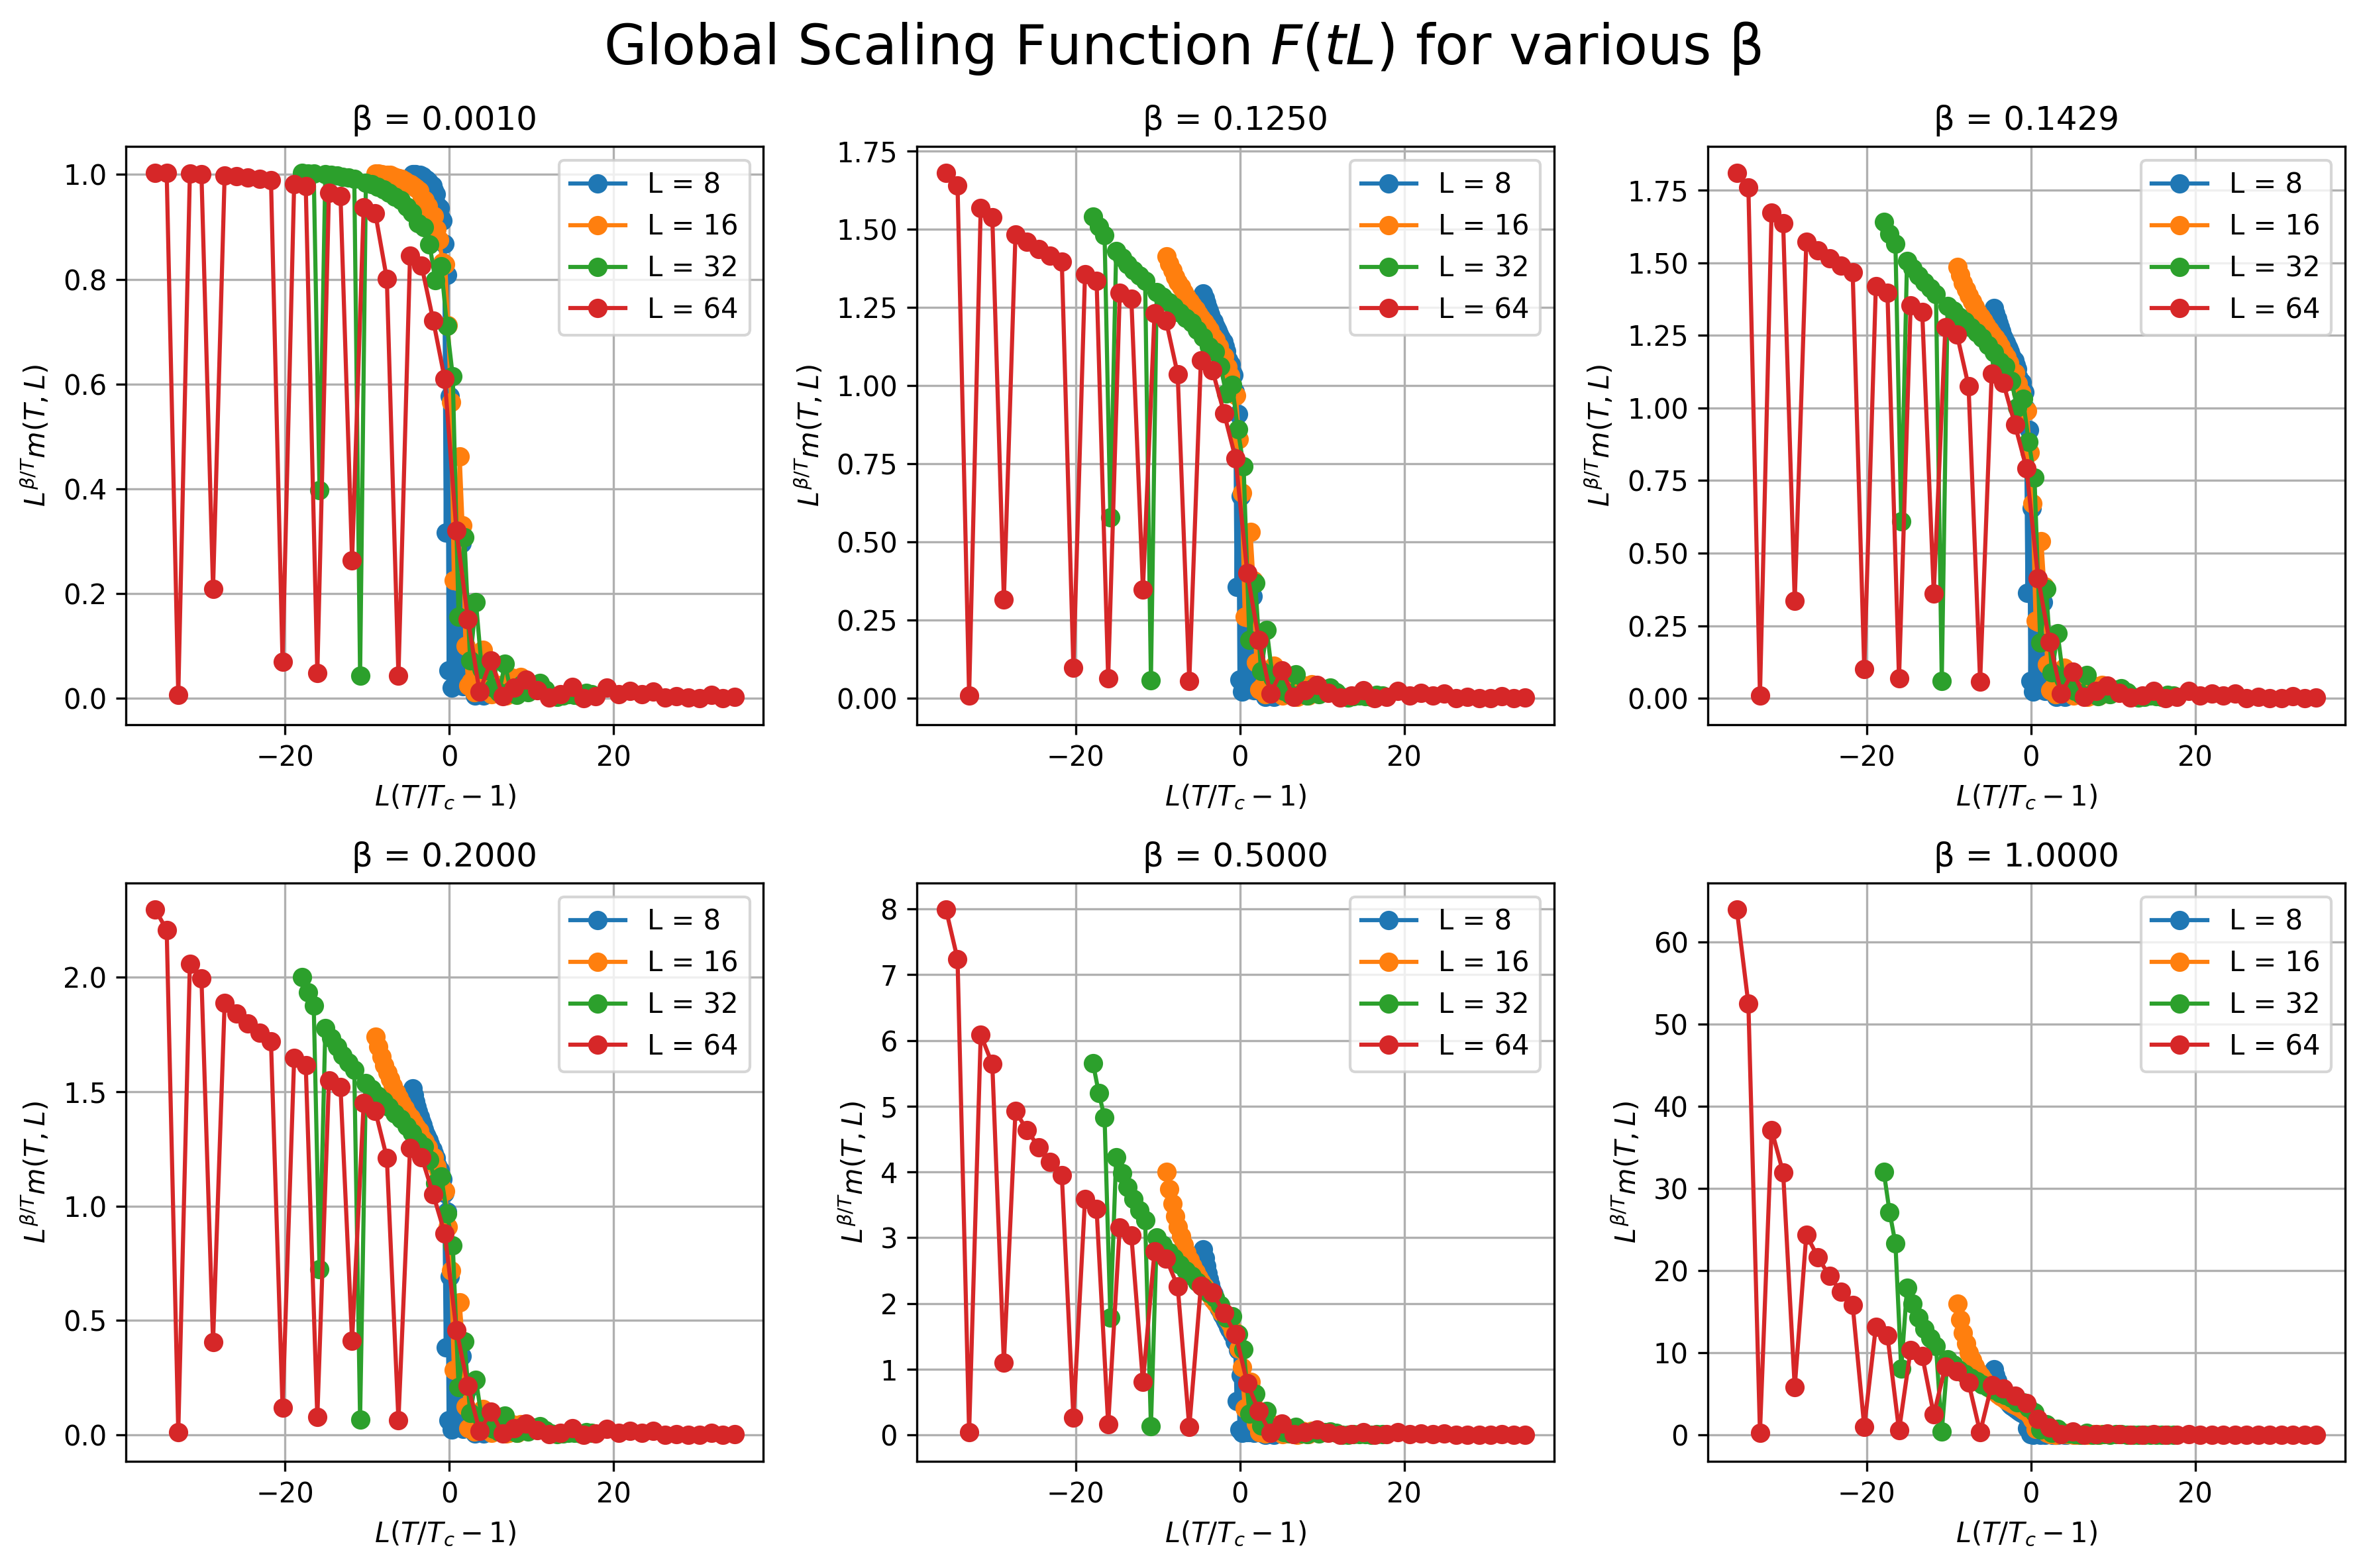

In [146]:
# just for global scaling
# Data[T][L]["energy", "magnetization"]
# - each index is a set of averaged temperatures
n_min = 800
# Extract unique lattice sizes (L) from the data
lattice_sizes = set()
for T in data:
    lattice_sizes.update(data[T].keys())
lattice_sizes = sorted(lattice_sizes)

# Define the set of beta values to loop over
beta_values = [1/1000, 1/8, 1/7, 1/5, 1/2, 1]

# Create a figure with subplots
fig5, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), dpi=300)
axes = axes.flatten()  # Flatten the 2x3 array of axes for easier iteration

# Loop over each beta value and plot the corresponding data
for i, beta in enumerate(beta_values):
    ax = axes[i]
    
    # Create a plot for each lattice size
    for L in lattice_sizes:
        temperatures = []
        magnetizations = []

        # Collect data for this lattice size
        for T in sorted(data.keys()):
            if L in data[T]:
                temperatures.append(T)
                # <M>
                magnetizations.append(np.mean(data[T][L]['magnetization'][n_min:]))  # Use mean of averaged energy

        # Plot energy vs temperature for this lattice size
        ax.plot(L * (np.array(temperatures)/2.269 - 1), 
                L**(beta/np.array(temperatures)) * np.abs(np.array(magnetizations))/(L**2), 
                marker='o', label=f'L = {L}')

    # Add labels and legend for each subplot
    fig5.suptitle("Global Scaling Function $F(tL)$ for various β", fontsize=20)
    ax.set_xlabel('$L(T/T_c - 1)$')
    ax.set_ylabel('$L^{β/T} m(T,L)$')
    ax.set_title(f'β = {beta:.4f}')
    ax.legend()
    ax.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()